<a href="https://colab.research.google.com/github/mit1280/A00444857_MCDA5510/blob/main/lion_identification_using_Kosmos2andSAM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lion Identification
Images are from https://stories.sandiegozoo.org/zoonooz/learn-your-lions/

### Install required packages

In [4]:
!pip install -qU transformers
# !pip install -qU accelerate peft bitsandbytes trl
!pip install -q einops flash_attn timm datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 68.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 412.2 kB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency

In [10]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd segment-anything-2

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 510, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 510 (delta 152), reused 68 (delta 68), pack-reused 304 (from 1)
Receiving objects: 100% (510/510), 88.45 MiB | 14.45 MiB/s, done.
Resolving deltas: 100% (160/160), done.
/content/segment-anything-2


In [11]:
!pip install -qe .

  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.9 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done


### Import libraries

In [1]:
import os
from transformers import AutoModelForCausalLM, AutoProcessor
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torch
from sam2.sam2_image_predictor import SAM2ImagePredictor
from PIL import Image, ImageDraw, ImageFont
import requests
import pandas as pd

/content/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


### Load Florence-2

In [2]:
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True,)
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True,)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
model = model.to(device)

## Run Florence-2 to identify animal

In [4]:
def run_example(task_prompt, image, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    print(prompt)
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    print(generated_text)
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [5]:
task_prompt = '<OD>'

In [6]:
predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large")

### Supportive functions

In [7]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

## Create DF

In [ ]:
df = pd.DataFrame({'image_path': ['Ernest.jpeg', 'Ernest2.jpeg', 'Ernest3.jpeg',
                                  'Miss Ellen.jpeg', 'Miss Ellen2.jpeg', 'Miss Ellen3.jpeg',
                                  'Ernest and Miss Ellen.jpeg', 'Ernest and Miss Ellen2.jpeg',]})

## Run for one lion

In [8]:
image_lion_ernest2 = Image.open('Ernest2.jpeg').convert('RGB')
# Image.open('Miss Ellen2.jpeg').convert('RGB')
print(image_lion_ernest2.size)
results = run_example(task_prompt, image_lion_ernest2)
print(results)

(800, 1177)
<OD>
</s><s>lion<loc_37><loc_0><loc_998><loc_946></s>
{'<OD>': {'bboxes': [[30.0, 0.5885000228881836, 798.7999877929688, 1114.030517578125]], 'labels': ['lion']}}


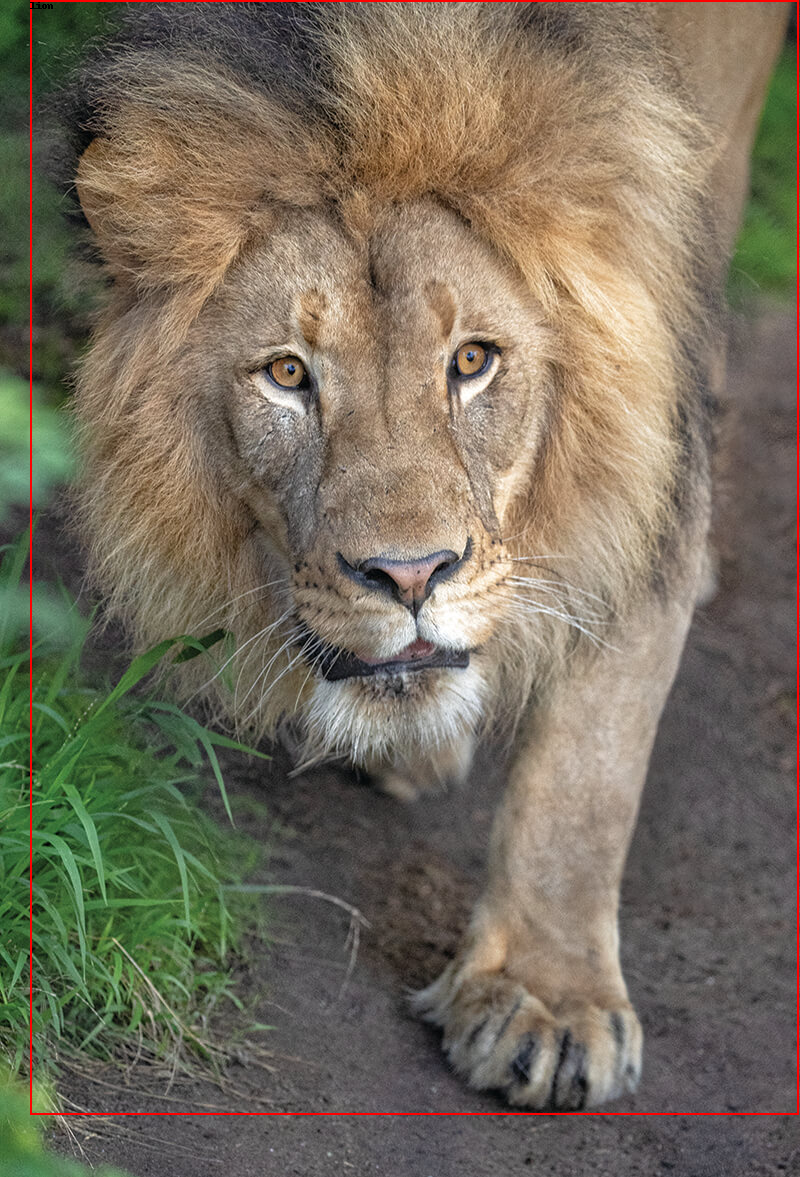

In [9]:
draw_1 = ImageDraw.Draw(image_lion_ernest2, "RGBA")
# We are visulizing boxes on original imag
for categorie, box in zip( results['<OD>']['labels'], results['<OD>']['bboxes']):
    # x, y, w, h = tuple(box) # the row comes in (left, top, width, height) format
    # print(box)
    # box = [x, y, w, h]
    draw_1.rectangle(box, outline="red", width=2)
    draw_1.text((box[0], box[1]), categorie, fill="black", size=20)

image_lion_ernest2

In [10]:
predictor.set_image(image_lion_ernest2)

### Use bounding box

In [11]:
input_boxes = np.array(results['<OD>']['bboxes'])

In [12]:
masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)
masks.shape

(1, 1177, 800)

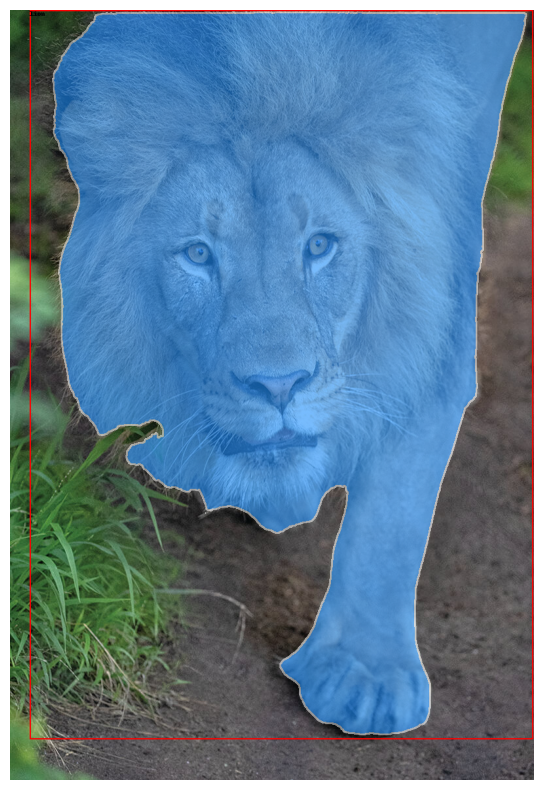

In [14]:
# plt.figure(figsize=(10, 10))
# plt.imshow(image_lion_ernest2)
# for mask in masks:
#     show_mask(mask.squeeze(0), plt.gca(), random_color=True)
# for box in input_boxes:
#     show_box(box, plt.gca())
# plt.axis('off')
# plt.show()
mask = masks[0]
plt.figure(figsize=(10, 10))
plt.imshow(image_lion_ernest2)
show_mask(mask, plt.gca())
plt.axis('off')
plt.show()

### Use center

In [ ]:
coordinates = results['<OD>']['bboxes'][0]
# Calculate the center
x_center = (coordinates[0] + coordinates[2]) / 2
y_center = (coordinates[1] + coordinates[3]) / 2

# The center coordinates
center = (x_center , y_center - 15)
center

(414.3999938964844, 542.3095088005066)

In [ ]:
input_point = np.array([list(center)])
input_label = np.array([1])

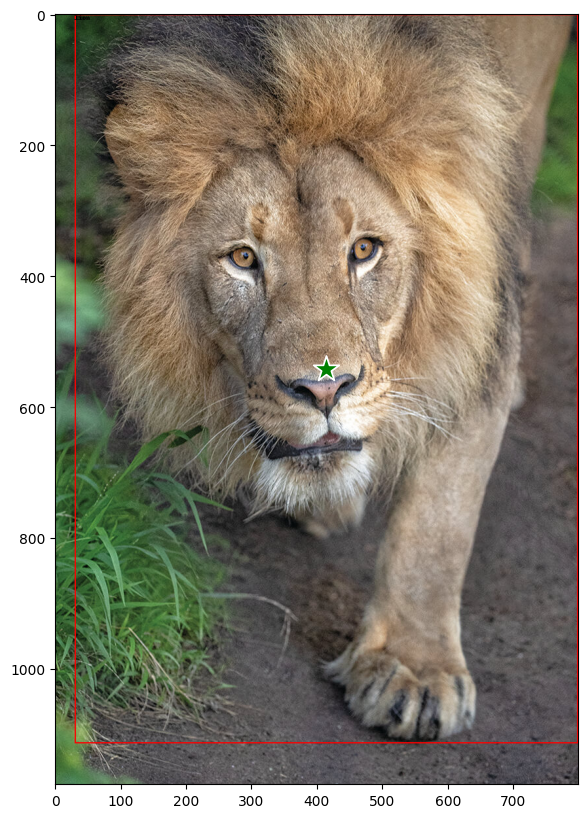

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image_lion_ernest2)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

In [ ]:
mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)
masks.shape

(1, 1177, 800)

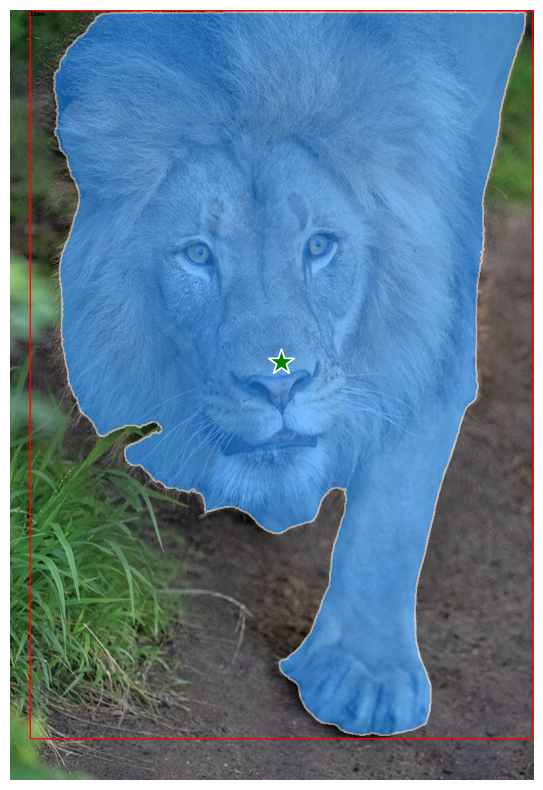

In [ ]:
show_masks(image_lion_ernest2, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

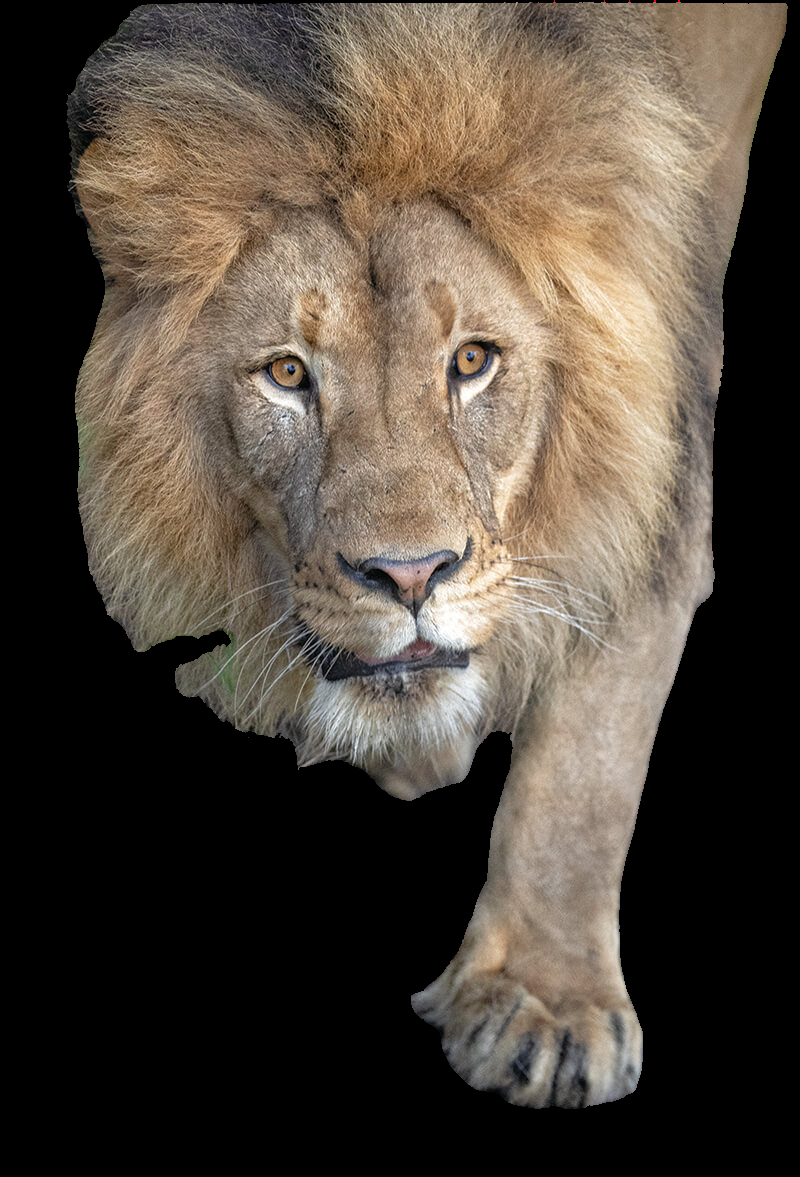

In [ ]:
# Convert the image to a NumPy array
image_np = np.array(image_lion_ernest2)

# Apply the mask to the image
masked_image_np = np.where(mask[:, :, None] == 1, image_np, 0)

# Convert back to PIL Image and display
masked_image = Image.fromarray(masked_image_np.astype('uint8'))
masked_image

### Perform Segmentation using SAM-2 for another lione (ignore)

In [ ]:
predictor.set_image(image_lion_ernest1)

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

In [ ]:
mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)
masks.shape

(1, 1600, 2400)

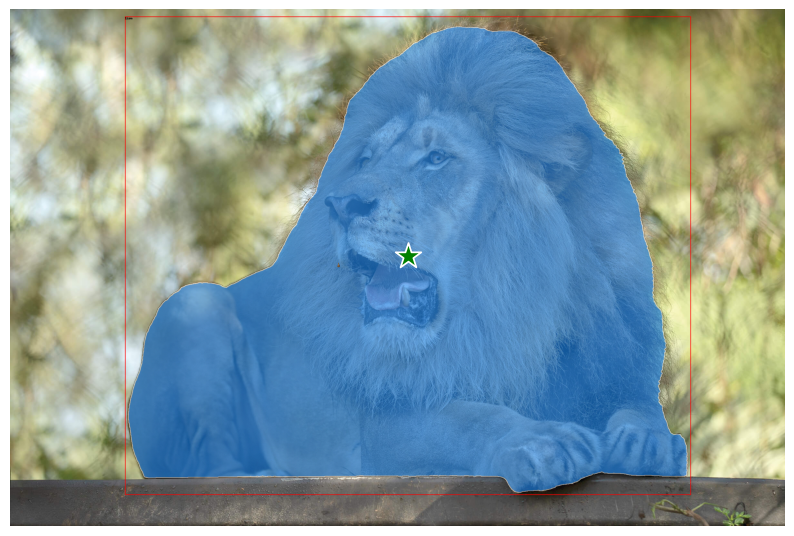

In [ ]:
show_masks(image_lion_ernest1, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

## Get Cropped image for all

In [ ]:
def get_cropped_image(df):
    image = Image.open(df['image_path']).convert('RGB')
    print(image.size)
    results = run_example(task_prompt, image)
    df['cropped_img'] = image.crop(results['<OD>']['bboxes'][0])
    df['label'] = results['<OD>']['labels'][0]
    df['bboxes'] = results['<OD>']['bboxes'][0]
    return df

In [ ]:
df = df.apply(get_cropped_image, axis=1)

(2400, 1600)
<OD>
</s><s>lion<loc_148><loc_14><loc_878><loc_939></s>
(800, 1177)
<OD>
</s><s>lion<loc_37><loc_0><loc_998><loc_946></s>
(2400, 1600)
<OD>
</s><s>lion<loc_0><loc_61><loc_813><loc_998></s>
(2400, 1600)
<OD>
</s><s>lion<loc_123><loc_23><loc_977><loc_878></s>


In [ ]:
def get_segmented_image(df):
    predictor.set_image(df['cropped_img'])
    width, height = df['cropped_img'].size
    center = [width // 2, (height // 2) - 15]
    input_point = np.array([center])
    input_label = np.array([1])
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    sorted_ind = np.argsort(scores)[::-1]
    masks = masks[sorted_ind]
    scores = scores[sorted_ind]
    logits = logits[sorted_ind]
    mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        mask_input=mask_input[None, :, :],
        multimask_output=False,
    )
    mask = masks[0]
    # Convert the image to a NumPy array
    image_np = np.array(df['cropped_img'])

    # Apply the mask to the image
    masked_image_np = np.where(mask[:, :, None] == 1, image_np, 0)

    # Convert back to PIL Image and display
    masked_image = Image.fromarray(masked_image_np.astype('uint8'))
    df['masked_image'] = masked_image
    return df

In [ ]:
df = df.apply(get_segmented_image, axis=1)

In [ ]:
import torch
from transformers import pipeline

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe = pipeline(task="image-feature-extraction", model_name="google/vit-base-patch16-384", device=DEVICE, pool=True)

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326 (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [ ]:
df

image_path                                        cropped_img label  \
0       Ernest.jpeg  <PIL.Image.Image image mode=RGB size=1752x1480...  lion   
1      Ernest2.jpeg  <PIL.Image.Image image mode=RGB size=769x1113 ...  lion   
2   Miss Ellen.jpeg  <PIL.Image.Image image mode=RGB size=1951x1500...  lion   
3  Miss Ellen2.jpeg  <PIL.Image.Image image mode=RGB size=2050x1368...  lion   

                                              bboxes  \
0  [356.4000244140625, 23.200000762939453, 2108.4...   
1  [30.0, 0.5885000228881836, 798.7999877929688, ...   
2  [1.2000000476837158, 98.4000015258789, 1952.40...   
3  [296.4000244140625, 37.60000228881836, 2346.0,...   

                                        masked_image  
0  <PIL.Image.Image image mode=RGB size=1752x1480...  
1  <PIL.Image.Image image mode=RGB size=769x1113 ...  
2  <PIL.Image.Image image mode=RGB size=1951x1500...  
3  <PIL.Image.Image image mode=RGB size=2050x1368...

In [ ]:
from torch.nn.functional import cosine_similarity

image_real = df.loc[0, 'masked_image']
image_gen = df.loc[1, 'masked_image']
outputs = pipe([image_real, image_gen])
similarity_score = cosine_similarity(torch.Tensor(outputs[0]),
                                     torch.Tensor(outputs[1]), dim=1)

print(similarity_score)
# Ernest.jpeg, Ernest2.jpeg - 0.9016

tensor([0.9016])


In [ ]:
image_real = df.loc[0, 'masked_image']
image_gen = df.loc[2, 'masked_image']
outputs = pipe([image_real, image_gen])
similarity_score = cosine_similarity(torch.Tensor(outputs[0]),
                                     torch.Tensor(outputs[1]), dim=1)

print(similarity_score)
# Ernest.jpeg, Miss Ellen.jpeg - 0.7419

tensor([0.7419])


In [ ]:
image_real = df.loc[0, 'masked_image']
image_gen = df.loc[3, 'masked_image']
outputs = pipe([image_real, image_gen])
similarity_score = cosine_similarity(torch.Tensor(outputs[0]),
                                     torch.Tensor(outputs[1]), dim=1)

print(similarity_score)
# Ernest.jpeg, Miss Ellen2.jpeg - 0.6350

tensor([0.6350])


In [ ]:
image_real = df.loc[1, 'masked_image']
image_gen = df.loc[2, 'masked_image']
outputs = pipe([image_real, image_gen])
similarity_score = cosine_similarity(torch.Tensor(outputs[0]),
                                     torch.Tensor(outputs[1]), dim=1)

print(similarity_score)
# Ernest2.jpeg, Miss Ellen.jpeg - 0.7719

tensor([0.7719])


In [ ]:
image_real = df.loc[1, 'masked_image']
image_gen = df.loc[3, 'masked_image']
outputs = pipe([image_real, image_gen])
similarity_score = cosine_similarity(torch.Tensor(outputs[0]),
                                     torch.Tensor(outputs[1]), dim=1)

print(similarity_score)
# Ernest2.jpeg, Miss Ellen2.jpeg - 0.6791

tensor([0.6791])


In [ ]:
image_real = df.loc[2, 'masked_image']
image_gen = df.loc[3, 'masked_image']
outputs = pipe([image_real, image_gen])
similarity_score = cosine_similarity(torch.Tensor(outputs[0]),
                                     torch.Tensor(outputs[1]), dim=1)

print(similarity_score)
# Miss Ellen.jpeg, Miss Ellen2.jpeg - 0.7253

tensor([0.7253])


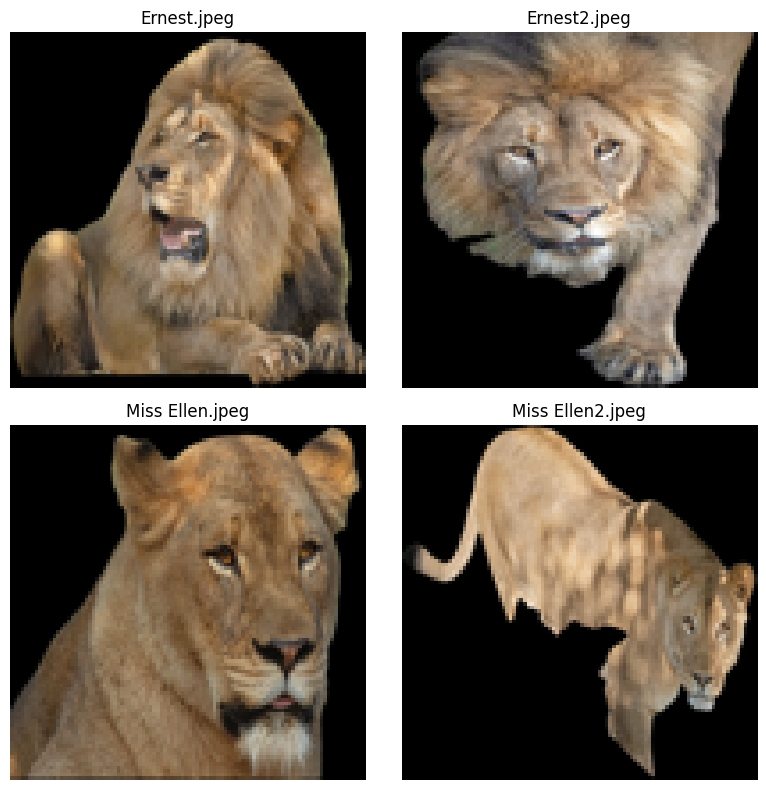

In [ ]:
# Desired size for the images (e.g., 100x100 pixels)
new_size = (100, 100)

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Loop through each image and name
for i, (image, name) in enumerate(zip(df['masked_image'].values.tolist(), df['image_path'].values.tolist())):
    # Open and resize the image

    image = image.resize(new_size)

    # Convert the image to display in matplotlib
    axes[i // 2, i % 2].imshow(image)
    axes[i // 2, i % 2].set_title(name)
    axes[i // 2, i % 2].axis('off')  # Hide axes

# Adjust layout and display the grid
plt.tight_layout()

plt.show()

In [ ]:
# Ernest.jpeg, Ernest2.jpeg - 0.9016
# Ernest.jpeg, Miss Ellen.jpeg - 0.7419
# Ernest.jpeg, Miss Ellen2.jpeg - 0.6350
# Ernest2.jpeg, Miss Ellen.jpeg - 0.7719
# Ernest2.jpeg, Miss Ellen2.jpeg - 0.6791
# Miss Ellen.jpeg, Miss Ellen2.jpeg - 0.7253